In [1]:
import numpy as np
import scipy.linalg as sla
import scipy.signal as sig
import scipy
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.model_selection import train_test_split, KFold
from IPython.display import display, Math, Latex
import wave
import struct

In [2]:
plt.rcParams["font.family"] = "Serif"
plt.rcParams.update({'font.size': 20})
col = ['b','r'];

In [3]:
def read_time_series(fname):
    
    d    = pd.read_csv(fname,header=None,skiprows=1,engine='python',sep='\s+');    
    darr = np.array(d);
    
    time = darr[:,0];
    Utt  = darr[:,1];
    
    return(time,Utt);

In [4]:
def get_PVOA_max(dirname, NTIME):
    
    PVA = np.zeros(NTIME);
    NLEAF = 3;
    for ileaf in range(NLEAF):
        fname = dirname + '\\rDOF{:03d}.dat'.format(ileaf+2);
        
        #d    = pd.read_csv(fname,header=None,skiprows=1,engine='python',sep='\s+'); 
        d      = pd.read_csv(fname,engine='python',sep='\s+'); 
        darr   = np.array(d);
        NR, NC = darr.shape;
        
        # Make 1D array 
        darr   = np.reshape(darr,[NR*NC]);
        
        # Remove 'VARIABLES' & '='
        NVARS  = NC - 2;
        darr   = darr[~np.isnan(darr)]; # Remove NaNs
        NT     = np.int(np.size(darr)/NVARS);
        darr   = np.reshape(darr,[NT,NVARS]);
        
        NWR    = np.min([NT,NTIME]);
        
        PVA[:NWR]   += darr[:NWR,4]; 
        
    PVOA = np.pi*(1.15**2) - PVA;
    #print(np.min(PVA))
    
    return(PVOA);

In [5]:
def write_mat_file(fmat, dictionary):
    
    scipy.io.savemat(fmat,dictionary);

In [6]:
def filter_signal(signal_in, threshold):
    
    NT = np.size(signal_in);
    
    signal_out = signal_in;
    norminf    = np.linalg.norm(signal_in,np.inf); 
    lim        = threshold*norminf;
    
    ind_loop   = np.arange(1,NT-1);
    
    for i in (ind_loop):
        sp = signal_in[i];
        sl = signal_in[i-1];
        su = signal_in[i+1];
        
        #Smooth peaks:
        if ( ( (sp-su) <= -lim and (sp-sl) <= -lim ) or
             ( (sp-su) >=  lim and (sp-sl) >=  lim ) ):
            
            signal_out[i] = 0.5*(su+sl);
            
    return(signal_out);

In [7]:
def interpolate_SMOTE(sig_in, NSIG_OUT, RANDSEED):
    
    HUGEFLOAT  = 1e10;
    
    NSIG_IN, NTIME = np.shape(sig_in);
    
    sig_out    = np.zeros([NSIG_OUT,NTIME]); 
    # Compute distance matrix:
    d2         = np.sum(np.square(sig_in - sig_in[:,np.newaxis,:]), axis=2);
    np.fill_diagonal(d2,HUGEFLOAT);
    indmin     = np.argmin(d2,axis=1);
    
    np.random.seed(RANDSEED);
    indInit = np.random.randint(0,high=NSIG_IN,size=NSIG_OUT);
    frac    = np.random.rand(NSIG_OUT);
    
    # SMOTE interpolation for new signals:
    for iout in range(NSIG_OUT):
        i = indInit[iout];
        j = indmin[i];
                
        sig_out[iout,:] = sig_in[i,:] + frac[iout]*(sig_in[j,:]-sig_in[i,:]);
        
    return(sig_out);

In [8]:
def SMA_signal(signal_in, width):
    
    NT = np.size(signal_in);
    signal_out = signal_in.copy();
    
    for i in np.arange(width,NT-width):
        il = np.int(np.max([0, i-np.floor(width/2)]));
        iu = np.int(np.min([NT,i+np.floor(width/2)]));
        
        signal_out[i] = np.mean(signal_in[il:iu]);
        
    return(signal_out);

In [9]:
def get_centered_scaled_signal(signals_in):
    
    
    signals_cent  = signals_in.copy();
    NSIGS, _      = np.shape(signals_in);
    
    #print(np.shape(signals_in))
    
    scale = np.zeros(NSIGS);
    
    # Scale the signal:
    for isig in range(NSIGS):
        scale[isig]          = 1./np.linalg.norm(signals_cent[isig,:],np.inf);
        signals_cent[isig,:] = signals_cent[isig,:]*scale[isig];
    
    # Center the dataset:
    meansig       = np.mean(signals_cent,axis=0);
    signals_cent -= meansig;
        
    return(signals_cent, meansig, scale);

In [10]:
#def get_omega(x_train, y_train, x_test, y_test, Nfeatures, SMW):
def get_omega(x_train, y_train, Nfeatures, SMW):
    
    '''
    Function to preprocess raw pressure history so that 
    it can be passed to classifier object. 
    
    Inputs:
    ------
    x_train    : Training Input vector
    y_train    : Training Output vector
    x_test     : Testing Input vector
    y_test     : Testing Output vector
    Nfeatures  : Number of dimensions to use from input vectors
    
    Outputs:
    -------
    omega      : Feature vector for training set
    omega_test : Feature vector for testing set
    Ytrain     : Reshaped training output vector
    Ytest      : Reshaped testing output vector
    '''

    nTrainTrials = np.shape(x_train)
    #nTestTrials  = np.shape(x_test)

    Ntrain = nTrainTrials[0];
    Ntime  = nTrainTrials[1];
    #Ntest  =  nTestTrials[0]*nTestTrials[1]

    # Reshape data:
    Xtrain = np.reshape(x_train,[Ntrain,Ntime]);
    Ytrain = np.reshape(y_train,[Ntrain]);
    
    # Smooth this signal:
    for i in range(Ntrain):
        Xtrain[i,:] = SMA_signal(Xtrain[i,:],SMW);

    #Scale and Center Data
    sdP, mu_train, scale_train = get_centered_scaled_signal(Xtrain);

               
    #--------------------------------------------------------------------------#      
    #SVD
    U,S,V = np.linalg.svd(sdP,full_matrices=False)

    #Feature Vector -- eliminates temporal dependence
    omega = np.dot(sdP,V[:Nfeatures,:].T)

    #Scale Omega
    print('Omega shape', np.shape(omega));
    omegamax = np.max(np.linalg.norm(omega[:,:], axis=1));
    omega    = omega/omegamax;
    
    # Create cumulative explained variance ratio:
    CuExVar = np.cumsum(np.square(S))/np.sum(np.square(S));

    return(omega, Ytrain, CuExVar, U, V, S);

In [11]:
def write_wave_file(y, Nreps, NT, Tp, fname, fname2):
    
    SzOut = Nreps*NT;
    
    # Scale output:
    y = y/np.linalg.norm(y,ord=np.inf);
    
    y2 = np.zeros(NT);
    y2[:np.size(y)] = y
    
    yout = [y2 for i in range(Nreps)];
    yout = np.reshape(yout,[SzOut]);
    
    t = np.linspace(0., Nreps*Tp, num=SzOut);
    
    f = wave.open(fname,'w');
    
    f2 = open(fname2,'w');
    f2.write('VARIABLES = time, An');
    
    f.setnchannels(1);
    f.setsampwidth(2);
    f.setframerate(int(SzOut/(Tp*Nreps)));
    f.setcomptype('NONE','Not Compressed');
    BinStr=b"";
    
    for i in range(np.size(yout)):
        BinStr += struct.pack('h',int(yout[i]*20000));
        
        f2.write('\n {:f} {:f}'.format(t[i], yout[i]));
        
    f.writeframesraw(BinStr);
    f.close();
    f2.close(); 

In [12]:
# Read dictionary data:

# Train set: 
dic_train = scipy.io.loadmat('train_set.mat');

sim_lab     = list(dic_train["sim_lab"]);
Utt_noF     = dic_train["Utt"];
NSIM, NTIME = np.shape(Utt_noF);
tag_noF     = dic_train["tag"];
time        = dic_train["time"].tolist();

# Additional synthesized:
dic_syn_train = scipy.io.loadmat('syn_train_set.mat');

syn_lab     = list(dic_syn_train["sim_lab"]);
Utt_syn     = dic_syn_train["Utt"];
NSYN, _     = np.shape(Utt_syn);
tag_syn     = dic_syn_train["tag"];

# Code to generate Utt_syn:
#seed = 7321;
#UttH = Utt_noF[tag_noF==0,:];
#nSyn = np.size(tag_noF) - np.sum(tag_noF);
#Utt_syn = interpolate_SMOTE(UttH, nSyn, seed);

alp  = [0.25,0.10];

# Reshape some arrays:
time    = np.reshape(time,NTIME);
tag_noF = np.array(np.reshape(tag_noF,NSIM));
tag_syn = np.array(np.reshape(tag_syn,NSYN));

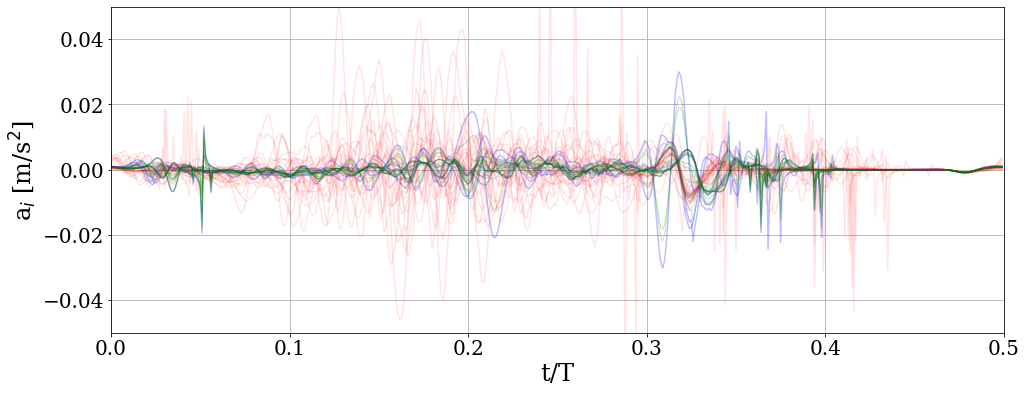

In [13]:
# Plot data:
plt.figure(figsize=(16,6));
for isim in range(NSIM):
    plt.plot(time,Utt_noF[isim,:]*100,c=col[tag_noF[isim]],alpha=alp[tag_noF[isim]]);
    
for isim in range(NSYN):
    plt.plot(time,Utt_syn[isim,:]*100,'g',lw=1,alpha=0.25);

plt.grid(True);
plt.xlim([0,0.5]);
plt.ylim([-0.05,0.05]);
plt.xlabel('t/T',fontsize=24);
plt.ylabel('a$_i$ [m/s$^2$]' ,fontsize=24);

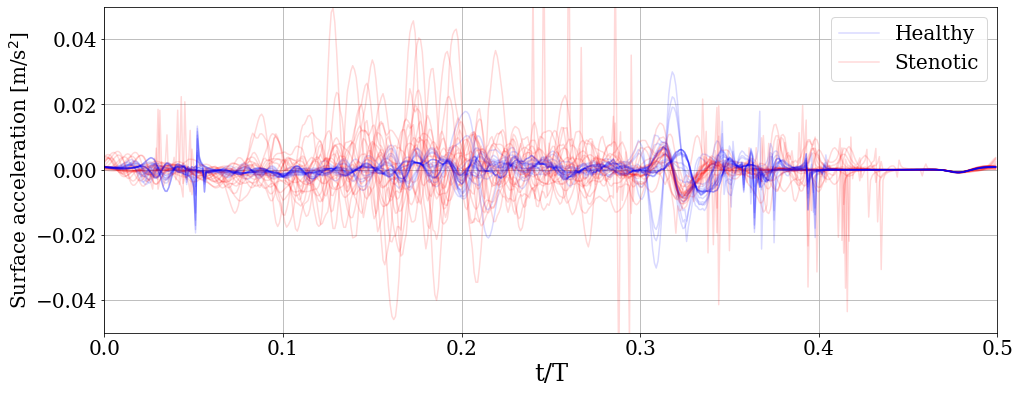

In [14]:
for i in range(NSYN):
    Utt_noF  = np.append(Utt_noF,[Utt_syn[i,:]],axis=0);
    tag_noF  = np.append(tag_noF,tag_syn[i]);

tag_noF = np.array([int(i) for i in tag_noF]);
    
NSIMS, _ = np.shape(Utt_noF);

iH = 0; iR = 0;
plt.figure(figsize=(16,6));
for isim in range(NSIMS):
    if (tag_noF[isim] == 0 and iH == 0):
        plt.plot(time,Utt_noF[isim,:]*100,c=col[tag_noF[isim]],alpha=0.15,label='Healthy');
        iH = 1;
    elif (tag_noF[isim] == 1 and iR == 0):
        plt.plot(time,Utt_noF[isim,:]*100,c=col[tag_noF[isim]],alpha=0.15,label='Stenotic');
        iR = 1;
    else:
        plt.plot(time,Utt_noF[isim,:]*100,c=col[tag_noF[isim]],alpha=0.15);

plt.grid(True);
plt.xlim([0,0.50]);
plt.ylim([-0.05,0.05]);
plt.xlabel('t/T',fontsize=24);
plt.ylabel('Surface acceleration [m/s$^2$]',fontsize=20);
plt.legend();

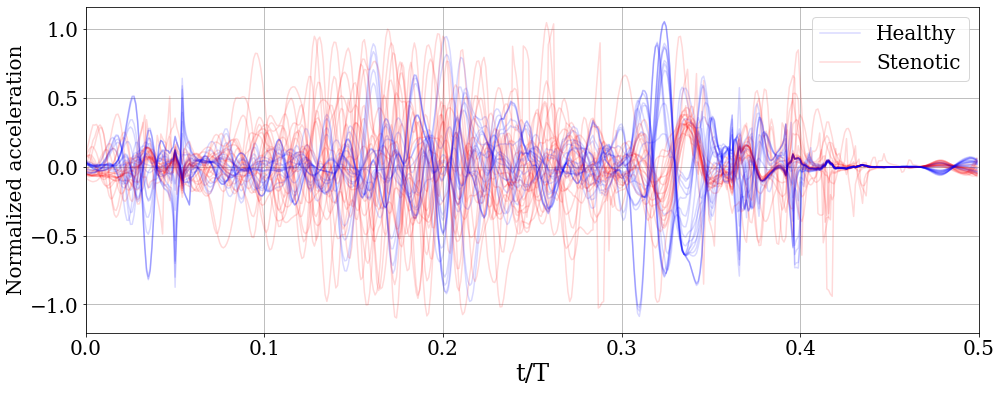

In [15]:
NSIMS, _ = np.shape(Utt_noF);
SMW   = 5;

Utt_sc = Utt_noF.copy();
for isim in range(NSIMS):
    Utt_sc[isim,:]   = SMA_signal(Utt_noF[isim,:],SMW)
    Utt_sc[isim,:]   = Utt_sc[isim,:]/np.linalg.norm(Utt_sc[isim,:],ord=np.inf);
meanUtt  = np.mean(Utt_sc,axis=0);

iH = 0; iR = 0;
plt.figure(figsize=(16,6));
for isim in range(NSIMS):
    yplt = Utt_sc[isim,:]-meanUtt;
    if (tag_noF[isim] == 0 and iH == 0):
        plt.plot(time,yplt,c=col[tag_noF[isim]],alpha=0.15,label='Healthy');
        iH = 1;
    elif (tag_noF[isim] == 1 and iR == 0):
        plt.plot(time,yplt,c=col[tag_noF[isim]],alpha=0.15,label='Stenotic');
        iR = 1;
    else:
        plt.plot(time,yplt,c=col[tag_noF[isim]],alpha=0.15);

plt.grid(True);
plt.xlim([0,0.50]);
plt.xlabel('t/T',fontsize=24);
plt.ylabel('Normalized acceleration',fontsize=20);
plt.legend();

Omega shape (44, 44)


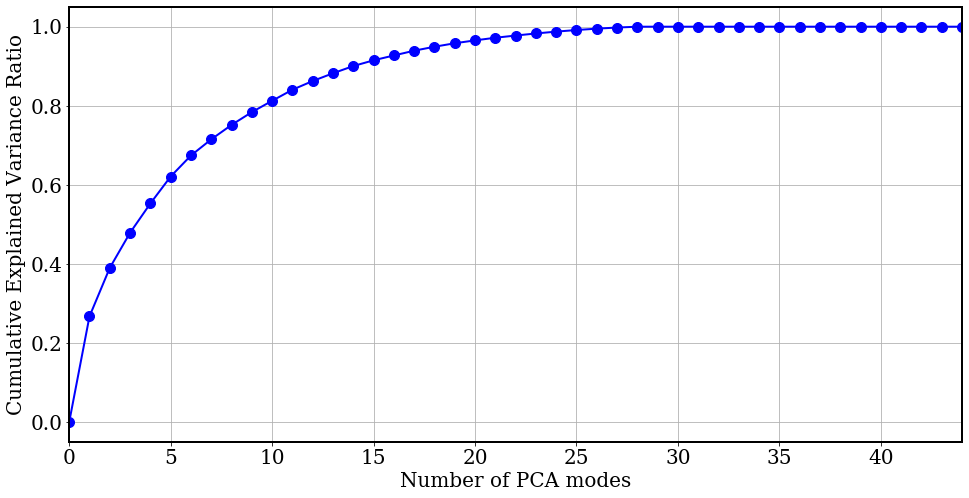

In [16]:
SMWindow = 5;

omega, Ytrain, CuExVar, U, V, S = get_omega(Utt_noF.copy(), tag_noF.copy(), NSIMS, SMWindow)

CuExVar = np.insert(CuExVar,0,0);

plt.figure(figsize=(16,8))
fig = plt.gcf();
ax  = fig.gca();

plt.plot(np.arange(0,NSIMS+1),CuExVar,'b-',lw=2,marker='o',markersize=10)
plt.grid(True)
plt.xlabel(r'Number of PCA modes');
plt.ylabel(r'Cumulative Explained Variance Ratio')
plt.xlim([0,NSIMS]);
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

# LDA:

In [17]:
def get_class_err(v0, v1, threshold):
    
    err = 0;
    
    err = err + np.sum(np.multiply((v0 > threshold),1));
    err = err + np.sum(np.multiply((v1 < threshold),1));
    
    err = np.float(err)/(np.size(v0)+np.size(v1));
    
    return(err);

In [18]:
def my_LDA(x_train, y_train, Nfeatures, SMW):

    omegaN, yy_train, CuExVar, _, _, _ = get_omega(x_train, y_train, Nfeatures, SMW);
     
    # LDA starts here
    omega0 = np.transpose(omegaN[yy_train == 0,:]);
    omega1 = np.transpose(omegaN[yy_train == 1,:]);

    N0  = np.size(yy_train[yy_train==0]);
    N1  = np.size(yy_train[yy_train==1]);
    
    mu0 = np.mean(omega0,axis=1);
    mu1 = np.mean(omega1,axis=1);
    
    Sb  = np.outer((mu0-mu1),(mu0-mu1));
    
    Sw  = 0;
    for iN in range(N0):
        Sw = Sw + np.outer((omega0[:,iN]-mu0),(omega0[:,iN]-mu0));
    for iN in range(N1):
        Sw = Sw + np.outer((omega1[:,iN]-mu1),(omega1[:,iN]-mu1));
                
    [D,V2]     = sla.eigh(Sb,Sw,eigvals_only=False);
    
    lam = np.max(np.abs(D));
    ind = np.argmax(np.abs(D));
    
    w = V2[:,ind];
    w = w/np.linalg.norm(w);
    
    v0 = np.dot(w,omega0); v1 = np.dot(w,omega1);
    
    result = [v0, v1];
    
    if np.mean(v0) > np.mean(v1):
        w   = -w;
        v0  = -v0;
        v1  = -v1;
    
    sortv0 = np.sort(v0);
    sortv1 = np.sort(v1);       
        
    t0 = np.size(sortv0)-1;
    t1 = 0;
    
    while( sortv0[t0] > sortv1[t1] ):
        t0 = np.max([t0 - 1, 0]);
        t1 = np.min([t1 + 1, N1-1]);
        
    # Normalize this new projection:
    shift  = np.min(sortv0)
    scale  = np.max(sortv1)-np.min(sortv0);
    sortv0 = ( sortv0 - shift )/scale;
    sortv1 = ( sortv1 - shift )/scale;
    
    threshold = (sortv0[t0]+sortv1[t1])/2;
    
    s0  = np.var(sortv0);
    s1  = np.var(sortv1);
    FDR = (np.mean(sortv1)-np.mean(sortv0))**2/(s0 + s1);

    
    Err = get_class_err(sortv0,sortv1,threshold);
    
    CM    = np.zeros([2,2]);
    
    return(sortv0, sortv1, threshold, FDR, Err, CM);

In [19]:
def plot_LDA_histogram(v0,v1,threshold):
    
    v0_N  = v0
    v1_N  = v1
    
    threshold_N = threshold
    
    bWidth = 0.05*(max(v1_N)-min(v0_N));
    bmin   = min(v0_N);
    bmax   = max(v1_N);
    brange = np.arange(bmin-bWidth, bmax+bWidth, bWidth);
    
    plt.figure(figsize=(16,8))
    fig = plt.gcf();
    ax  = fig.gca();
    
    plt.subplot(1,1,1)
    y0, x0, _ = plt.hist(v0_N, bins=brange, color='cyan', alpha=0.5, edgecolor='k', linewidth=2, label='Healthy')
    y1, x1, _ = plt.hist(v1_N, bins=brange, color='red', alpha=0.5, edgecolor='k', linewidth=2, label='RLM')

    # Y-scale
    yscale = np.max([y0.max(), y1.max()]);
    yscale = (np.floor(yscale/5) + 1)*5;
    
    plt.plot([threshold_N, threshold_N], [0, 50], 'k--',lw=4, label='Threshold')
    plt.grid(True);
    plt.ylim([0, yscale]);
    plt.xlabel(r'Discrimination Index');
    plt.ylabel(r'Number of valves')
    plt.legend()

    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
    plt.show()

Omega shape (44, 18)


C:\Users\sbailoo1\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


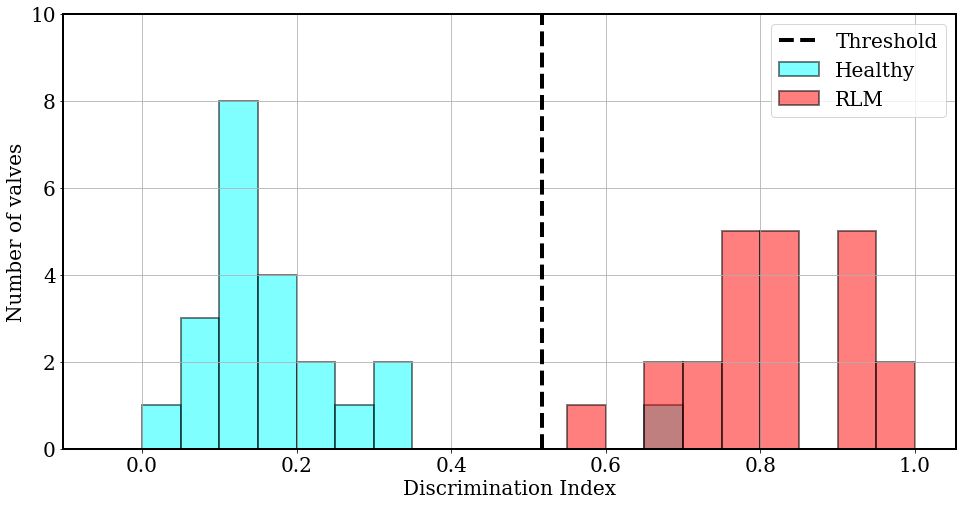

In [20]:
Nfeatures = 18;

sortv0, sortv1, threshold, FDR, Err, CM = my_LDA(Utt_noF.copy(), tag_noF.copy(), Nfeatures, SMW);

plot_LDA_histogram(sortv0,sortv1,threshold)

# Cross-Validation:

In [21]:
def get_centered_scaled_signal_full(signals_in, signals_in_test):
    
    
    signals_cent      = signals_in.copy();
    signals_cent_test = signals_in_test.copy();
    
    NSIMS, _      = np.shape(signals_in);
    NSIMS_test, _ = np.shape(signals_in_test);
    
    scale_train   = np.zeros(NSIMS);
    scale_test    = np.zeros(NSIMS_test);
    
    # Scale the signal:
    for isim in range(NSIMS):
        scale_train[isim]    = 1./np.linalg.norm(signals_cent[isim,:],np.inf);
        signals_cent[isim,:] = signals_cent[isim,:]*scale_train[isim];
        
    for isim in range(NSIMS_test):
        scale_test[isim]          = 1./np.linalg.norm(signals_cent_test[isim,:],np.inf); 
        signals_cent_test[isim,:] = signals_cent_test[isim,:]*scale_test[isim];
    
    # Center the dataset:
    meansig            = np.mean(signals_cent,axis=0);
    signals_cent      -= meansig;
    signals_cent_test -= meansig;
        
    return(signals_cent, signals_cent_test, meansig, scale_train, scale_test);

In [22]:
def normalized_to_phys_full(S_train, mean, scale_train):
    
    NTRAIN, _ = np.shape(S_train);
    #NTEST,  _ = np.shape(S_test);
    
    sig_train = np.zeros_like(S_train);
    #sig_test  = np.zeros_like(S_test);
    
    for i in range(NTRAIN):
        sig_train[i,:] = (S_train[i,:] + mean)/scale_train[i];
    
    #for i in range(NTEST):
    #    sig_test[i,:] = (S_test[i,:] + mean)/scale_test[i];
        
    #return(sig_train, sig_test);
    return(sig_train);

In [23]:
def get_omega_full(x_train, y_train, x_test, y_test, Nfeatures, SMW):

    
    '''
    Function to preprocess raw pressure history so that 
    it can be passed to classifier object. 
    
    Inputs:
    ------
    x_train    : Training Input vector
    y_train    : Training Output vector
    x_test     : Testing Input vector
    y_test     : Testing Output vector
    Nfeatures  : Number of dimensions to use from input vectors
    
    Outputs:
    -------
    omega      : Feature vector for training set
    omega_test : Feature vector for testing set
    Ytrain     : Reshaped training output vector
    Ytest      : Reshaped testing output vector
    '''

    nTrainTrials = np.shape(x_train)
    nTestTrials  = np.shape(x_test)

    Ntrain = nTrainTrials[0];
    Ntime  = nTrainTrials[1];
    Ntest  =  nTestTrials[0];

    # Reshape data:
    Xtrain = np.reshape(x_train,[Ntrain,Ntime]);
    Ytrain = np.reshape(y_train,[Ntrain]);
    Xtest  = np.reshape(x_test,[Ntest,Ntime]); 
    Ytest  = np.reshape(y_test,[Ntest]);
    
    # Smooth this signal:
    for i in range(Ntrain):
        Xtrain[i,:] = SMA_signal(Xtrain[i,:],SMW);
    for i in range(Ntest):
        Xtest[i,:]  = SMA_signal(Xtest[i,:],SMW);

    #Scale and Center Data
    sdP, sdP_test, meansig, scale_train, scale_test = get_centered_scaled_signal_full(Xtrain, Xtest);

               
    #--------------------------------------------------------------------------#      
    #SVD
    U,S,V = np.linalg.svd(sdP,full_matrices=False)

    #Feature Vector -- eliminates temporal dependence
    omega = np.dot(sdP,V[:Nfeatures,:].T)

    #Scale Omega
    #print('Omega shape', np.shape(omega));
    omegamax = np.max(np.linalg.norm(omega[:,:], axis=1));
    omega    = omega/omegamax;
    
    # Create cumulative explained variance ratio:
    CuExVar = np.cumsum(np.square(S))/np.sum(np.square(S));


    omega_test = np.dot(sdP_test,V[:Nfeatures,:].T);
    omega_test = omega_test/omegamax;
    
    return(omega, Ytrain, omega_test, Ytest, CuExVar);

In [24]:
def get_omega_full_USV(x_train, y_train, x_test, y_test, Nfeatures, SMW):

    
    '''
    Function to preprocess raw pressure history so that 
    it can be passed to classifier object. 
    
    Inputs:
    ------
    x_train    : Training Input vector
    y_train    : Training Output vector
    x_test     : Testing Input vector
    y_test     : Testing Output vector
    Nfeatures  : Number of dimensions to use from input vectors
    
    Outputs:
    -------
    omega      : Feature vector for training set
    omega_test : Feature vector for testing set
    Ytrain     : Reshaped training output vector
    Ytest      : Reshaped testing output vector
    '''

    nTrainTrials = np.shape(x_train)
    nTestTrials  = np.shape(x_test)

    Ntrain = nTrainTrials[0];
    Ntime  = nTrainTrials[1];
    Ntest  =  nTestTrials[0];

    # Reshape data:
    Xtrain = np.reshape(x_train,[Ntrain,Ntime]);
    Ytrain = np.reshape(y_train,[Ntrain]);
    Xtest  = np.reshape(x_test,[Ntest,Ntime]); 
    Ytest  = np.reshape(y_test,[Ntest]);
    
    # Smooth this signal:
    for i in range(Ntrain):
        Xtrain[i,:] = SMA_signal(Xtrain[i,:],SMW);
    for i in range(Ntest):
        Xtest[i,:]  = SMA_signal(Xtest[i,:],SMW);

    #Scale and Center Data
    sdP, sdP_test, meansig, scale_train, scale_test = get_centered_scaled_signal_full(Xtrain, Xtest);

               
    #--------------------------------------------------------------------------#      
    #SVD
    U,S,V = np.linalg.svd(sdP,full_matrices=False)

    #Feature Vector -- eliminates temporal dependence
    omega = np.dot(sdP,V[:Nfeatures,:].T)

    #Scale Omega
    #print('Omega shape', np.shape(omega));
    omegamax = np.max(np.linalg.norm(omega[:,:], axis=1));
    omega    = omega/omegamax;
    
    # Create cumulative explained variance ratio:
    CuExVar = np.cumsum(np.square(S))/np.sum(np.square(S));


    omega_test = np.dot(sdP_test,V[:Nfeatures,:].T);
    omega_test = omega_test/omegamax;
    
    SingVec = [U, S, V];
    
    MeanScale = [meansig, scale_train, scale_test];
    
    return(omega, Ytrain, omega_test, Ytest, CuExVar, SingVec, MeanScale);

In [25]:
def my_LDA_full(x_train, y_train, x_test, y_test, Nfeatures, SMW):
        
    omegaN, yy_train, omegaN_test, yy_test, CuExVar = get_omega_full(x_train, y_train, 
                                                                     x_test,  y_test, Nfeatures, SMW);    
    
    # LDA starts here
    omega0 = np.transpose(omegaN[yy_train == 0,:]);
    omega1 = np.transpose(omegaN[yy_train == 1,:]);
    
    # Test data
    omega0_test = np.transpose(omegaN_test[yy_test == 0,:]);
    omega1_test = np.transpose(omegaN_test[yy_test == 1,:]);
    
    N0  = np.size(yy_train[yy_train==0]);
    N1  = np.size(yy_train[yy_train==1]);
    
    mu0 = np.mean(omega0,axis=1);
    mu1 = np.mean(omega1,axis=1);
    
    Sb  = np.outer((mu0-mu1),(mu0-mu1));
    
    Sw  = 0;
    for iN in range(N0):
        Sw = Sw + np.outer((omega0[:,iN]-mu0),(omega0[:,iN]-mu0));
    for iN in range(N1):
        Sw = Sw + np.outer((omega1[:,iN]-mu1),(omega1[:,iN]-mu1));
                
    [D,V2]     = sla.eigh(Sb,Sw,eigvals_only=False);
    
    lam = np.max(np.abs(D));
    ind = np.argmax(np.abs(D));
    
    w = V2[:,ind];
    w = w/np.linalg.norm(w);
    
    #print(np.shape(w), np.shape(w))

    v0 = np.dot(w,omega0); v1 = np.dot(w,omega1);
    
    result = [v0, v1];
    
    if np.mean(v0) > np.mean(v1):
        w   = -w;
        v0  = -v0;
        v1  = -v1;
    
    sortv0 = np.sort(v0);
    sortv1 = np.sort(v1);       
        
    t0 = np.size(sortv0)-1;
    t1 = 0;
    
    while( sortv0[t0] > sortv1[t1] ):
        t0 = np.max([t0 - 1, 0]);
        t1 = np.min([t1 + 1, N1-1]);
        
    # Normalize this new projection:
    shift  = np.min(sortv0)
    scale  = np.max(sortv1)-np.min(sortv0);
    sortv0 = ( sortv0 - shift )/scale;
    sortv1 = ( sortv1 - shift )/scale;
    
    threshold = (sortv0[t0]+sortv1[t1])/2;
    
    #print('sortv0[t0]',sortv0[t0])
    #print('sortv1[t1]',sortv1[t1])
    #print('threshold',threshold)
    
    s0  = np.var(sortv0); #np.sum( np.square(sortv0 - np.mean(sortv0)) ); 
    s1  = np.var(sortv1); #np.sum( np.square(sortv1 - np.mean(sortv1)) );
    FDR = (np.mean(sortv1)-np.mean(sortv0))**2/(s0 + s1);
    
    # LDA projections for test set:
    testv0 = np.sort(np.dot(w,omega0_test));
    testv1 = np.sort(np.dot(w,omega1_test));
    
    testv0 = (testv0 - shift)/scale;
    testv1 = (testv1 - shift)/scale;
    
    Err = [get_class_err(sortv0,sortv1,threshold), get_class_err(testv0,testv1,threshold)];
    
    #print(np.mean(sortv1)-np.mean(sortv0))
    #print(np.std(sortv0), np.std(sortv1))
    
    CM    = np.zeros([2,2]);
    yypred = np.dot(w,omegaN_test.T);
    yypred = (yypred - shift)/scale;

    yypred[yypred < threshold] = 0;
    yypred[yypred > threshold] = 1;
    
    one_arr = np.ones_like(yypred);
    
    CM[0,0] = np.sum(one_arr[np.logical_and(yy_test==1,yypred==1)]) # TP
    CM[0,1] = np.sum(one_arr[np.logical_and(yy_test==0,yypred==1)]) # FP
    CM[1,0] = np.sum(one_arr[np.logical_and(yy_test==1,yypred==0)]) # FN
    CM[1,1] = np.sum(one_arr[np.logical_and(yy_test==0,yypred==0)]) # TN
    
    return(sortv0, sortv1, testv0, testv1, threshold, w, FDR, Err, CM);
    #return(sortv0, sortv1, threshold, FDR, Err, CM);

In [26]:
def plot_LDA_histogram_full(v0,v1,v0T,v1T,threshold,ShowTest):
    
    v0_N  = v0
    v1_N  = v1
    v0T_N = v0T
    v1T_N = v1T
    
    N0T   = np.size(v0T);
    N1T   = np.size(v1T);
    
    minT  = 0;
    maxT  = 1;
    if (N0T > 0):
        minT = np.min(v0T);
    if (N1T > 0):
        maxT = np.max(v1T);
    
    threshold_N = threshold
    
    bWidth = 0.05*(max(v1_N)-min(v0_N));
    bmin   = min([min(v0_N), minT]);
    bmax   = max([max(v1_N), maxT]);
    
    brange = np.arange(bmin-bWidth, bmax+bWidth, bWidth);
    
    plt.figure(figsize=(16,8))
    fig = plt.gcf();
    ax  = fig.gca();
    
    #print('v0N',v0_N)
    #print('v1N',v1_N)
    
    plt.subplot(1,1,1)
    y0, x0, _ = plt.hist(v0_N, bins=brange, color='cyan', alpha=0.5, edgecolor='k', linewidth=2, label='Healthy')
    y1, x1, _ = plt.hist(v1_N, bins=brange, color='red', alpha=0.5, edgecolor='k', linewidth=2, label='Stenotic')
    if ShowTest == 1:
        if N0T > 0:
            y0T, x0T, _ = plt.hist(v0T_N, bins=brange, color='blue', alpha=0.5, edgecolor='k', linewidth=2, label='Healthy -- test')
        if N1T > 0:
            y1T, x1T, _ = plt.hist(v1T_N, bins=brange, color='orange', alpha=0.5, edgecolor='k', linewidth=2, label='Stenotic -- test')
    
    
    # Y-scale
    yscale = np.max([y0.max(), y1.max()]);
    yscale = (np.floor(yscale/5) + 1)*5;
    
    plt.plot([threshold_N, threshold_N], [0, 50], 'k--',lw=4, label='Threshold')
    plt.grid(True);
    plt.ylim([0, yscale]);
    plt.xlabel(r'Discrimination Index');
    plt.ylabel(r'Number of valves')
    plt.legend()

    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
    plt.show()
    

In [27]:
NFOLDS = 10
KF = KFold(n_splits=NFOLDS,shuffle=True,random_state=10);

NFeatMax = 24; #np.int(NSIMS*(NFOLDS-1)/NFOLDS) - 2;
print('NSIMS ',NSIMS)

Err_LDA = np.zeros([NFeatMax,NFOLDS,2]);

for ifeat in range(NFeatMax):
    
    NFeatures = ifeat + 1;
    print('')
    print('-------------------------------------------------')
    print('Testing NFeatures:', NFeatures)
    
    ifold = 0;
    for train_index, val_index in KF.split(Utt_noF):
        print("Validation size:", np.size(val_index));
        
        x_train = Utt_noF[train_index,:]; y_train = tag_noF[train_index];
        x_valid = Utt_noF[val_index,:];   y_valid = tag_noF[val_index];

        v0, v1, v0T, v1T, thresh, w, FDR, Err, CM = my_LDA_full(x_train.copy(), y_train.copy(), 
                                                             x_valid.copy(), y_valid.copy(), 
                                                             Nfeatures=NFeatures, SMW=SMW);
        
        Err_LDA[ifeat,ifold,:] += Err;
        ifold += 1;
        print('Error', Err)

NSIMS  44

-------------------------------------------------
Testing NFeatures: 1
Validation size: 5
Error [0.15384615384615385, 0.2]
Validation size: 5
Error [0.1794871794871795, 0.2]
Validation size: 5
Error [0.20512820512820512, 0.2]
Validation size: 5
Error [0.28205128205128205, 0.0]
Validation size: 4
Error [0.225, 0.5]
Validation size: 4
Error [0.15, 0.75]
Validation size: 4
Error [0.225, 0.25]
Validation size: 4
Error [0.2, 0.0]
Validation size: 4
Error [0.25, 0.25]
Validation size: 4
Error [0.2, 0.25]

-------------------------------------------------
Testing NFeatures: 2
Validation size: 5
Error [0.15384615384615385, 0.4]
Validation size: 5
Error [0.15384615384615385, 0.2]
Validation size: 5
Error [0.15384615384615385, 0.2]
Validation size: 5
Error [0.1794871794871795, 0.0]
Validation size: 4
Error [0.175, 0.0]
Validation size: 4
Error [0.125, 0.5]
Validation size: 4
Error [0.15, 0.25]
Validation size: 4
Error [0.175, 0.0]
Validation size: 4
Error [0.175, 0.0]
Validation size:

Error [0.02564102564102564, 0.2]
Validation size: 5
Error [0.02564102564102564, 0.0]
Validation size: 5
Error [0.02564102564102564, 0.2]
Validation size: 4
Error [0.025, 0.25]
Validation size: 4
Error [0.0, 0.25]
Validation size: 4
Error [0.025, 0.25]
Validation size: 4
Error [0.025, 0.0]
Validation size: 4
Error [0.025, 0.0]
Validation size: 4
Error [0.025, 0.0]

-------------------------------------------------
Testing NFeatures: 18
Validation size: 5
Error [0.0, 0.0]
Validation size: 5
Error [0.0, 0.2]
Validation size: 5
Error [0.02564102564102564, 0.0]
Validation size: 5
Error [0.0, 0.4]
Validation size: 4
Error [0.0, 0.0]
Validation size: 4
Error [0.0, 0.25]
Validation size: 4
Error [0.0, 0.25]
Validation size: 4
Error [0.025, 0.0]
Validation size: 4
Error [0.025, 0.0]
Validation size: 4
Error [0.025, 0.0]

-------------------------------------------------
Testing NFeatures: 19
Validation size: 5
Error [0.0, 0.0]
Validation size: 5
Error [0.02564102564102564, 0.2]
Validation size:

Min Validation error: 0.085  at  19  modes.


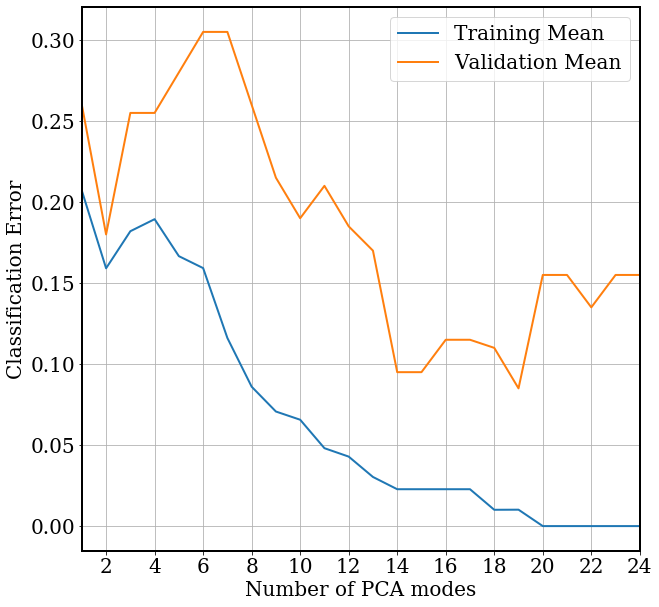

In [28]:
Err_mean = np.mean(Err_LDA,axis=1);

print('Min Validation error:', np.min(Err_mean[:,1]), ' at ', np.argmin(Err_mean[:,1])+1, ' modes.')

plt.figure(figsize=(10,10));
plt.plot(np.arange(NFeatMax)+1,Err_mean[:,0],label='Training Mean',lw=2)
plt.plot(np.arange(NFeatMax)+1,Err_mean[:,1],label='Validation Mean',lw=2)
plt.grid(True)
plt.xticks(np.arange(NFeatMax+1,step=2));
plt.xlim([1,NFeatMax]);
#plt.ylim([-0.01,0.26]);
plt.xlabel('Number of PCA modes');
plt.ylabel('Classification Error');
plt.legend();

fig = plt.gcf();
ax  = fig.gca();
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

C:\Users\sbailoo1\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


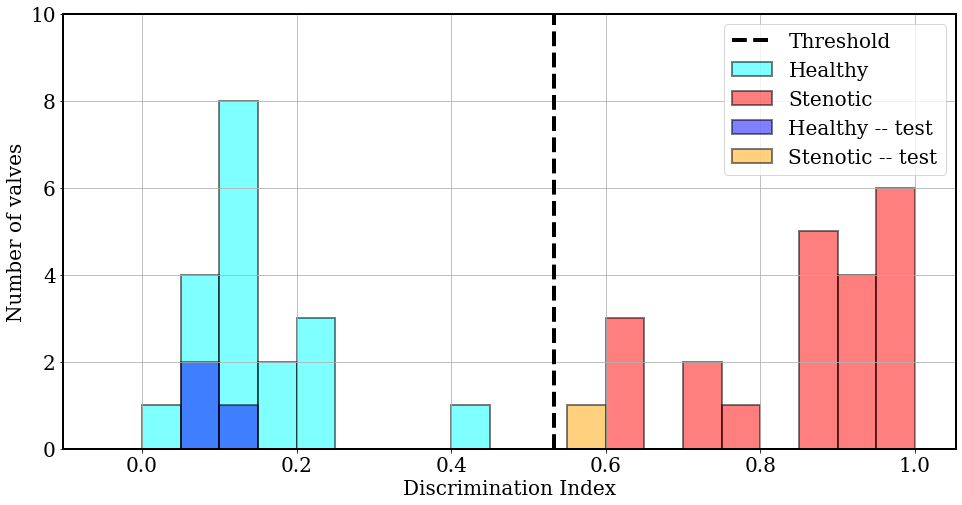

In [29]:
v0, v1, v0T, v1T, thresh, w, _, Err, _ = my_LDA_full(x_train.copy(), y_train.copy(), 
                                                             x_valid.copy(), y_valid.copy(), 
                                                             Nfeatures=22, SMW=SMW);

plot_LDA_histogram_full(v0,v1,v0T,v1T,thresh,1)

# Test data:

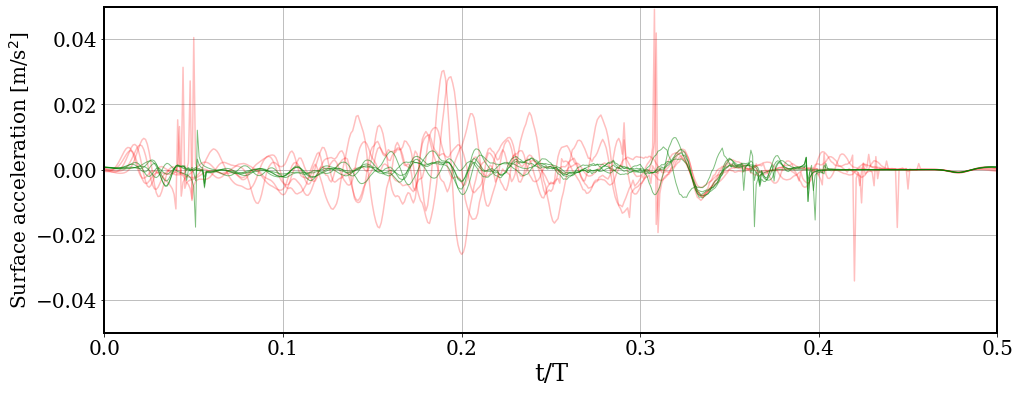

In [30]:
# Train set: 
dic_test = scipy.io.loadmat('test_set.mat');

sim_labT     = list(dic_test["sim_lab"]);
Utt_T        = dic_test["Utt"];
NSIMT, _     = np.shape(Utt_T);
tag_T        = dic_test["tag"];
#time        = dic_test["time"].tolist();

# Additional synthesized healthy:
dic_syn_train = scipy.io.loadmat('syn_test_set.mat');

syn_labT     = list(dic_syn_train["sim_lab"]);
Utt_synT     = dic_syn_train["Utt"];
NSYNT, _     = np.shape(Utt_synT);
tag_synT     = dic_syn_train["tag"];

## Code to generate Utt_synT:
#seedT       = 6949;
#UttH        = Utt_noF[tag_noF==0,:];
#NSYNT       = np.size(tag_T) - np.sum(tag_T);
#Utt_syn     = interpolate_SMOTE(UttH, NSYNT, seedT);
#tag_synT    = np.zeros(NSYNT);

tag_T    = np.array(np.reshape(tag_T,NSIMT),dtype=int);
tag_synT = np.array(np.reshape(tag_synT,NSYNT),dtype=int);

# Plot test data:
plt.figure(figsize=(16,6))
for isim in range(NSIMT):
    plt.plot(time,Utt_T[isim,:]*100,c=col[tag_T[isim]],alpha=0.25);
    
for isim in range(NSYNT):
    plt.plot(time,Utt_synT[isim,:]*100,'g',lw=1,alpha=0.5);
    
plt.grid(True);
plt.xlim([0,0.5]);
plt.ylim([-0.05,0.05])
plt.xlabel('t/T',fontsize=24)
plt.ylabel('Surface acceleration [m/s$^2$]',fontsize=20);
fig = plt.gcf(); ax = plt.gca();
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

In [31]:
for i in range(NSYNT):
    Utt_T  = np.append(Utt_T,[Utt_synT[i,:]],axis=0);
    tag_T  = np.append(tag_T,tag_synT[i]);
            
NSIMST, _ = np.shape(Utt_T);

Utt_T_smo = np.zeros_like(Utt_T);
for isim in range(NSIMST):
    Utt_T_smo[isim,:] = SMA_signal(Utt_T[isim,:],SMW);

(44, 500) (10, 500)


C:\Users\sbailoo1\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


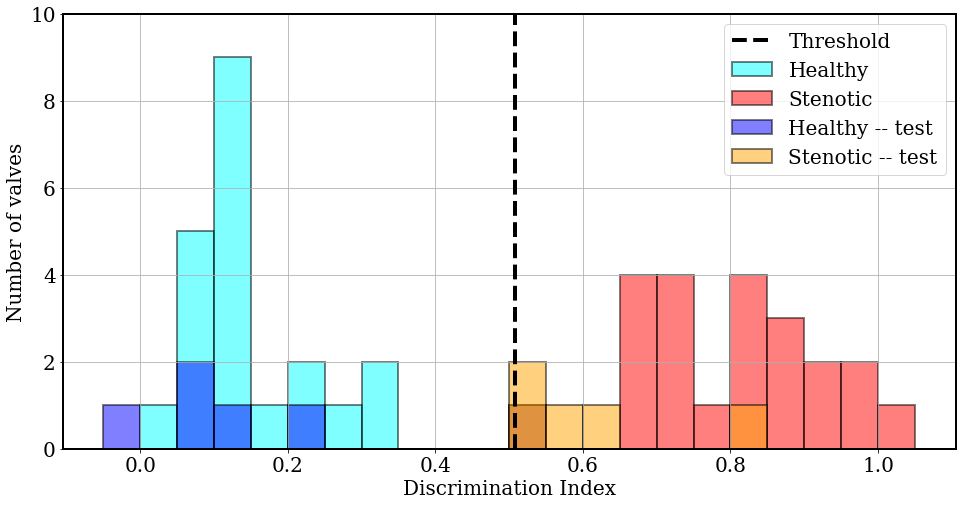

In [32]:
x_train = Utt_noF; x_test = Utt_T; 
y_train = tag_noF; y_test = tag_T;

print(np.shape(x_train), np.shape(x_test))

v0, v1, v0T, v1T, thresh, w, FDR, Err, CM = my_LDA_full(x_train.copy(), y_train.copy(), 
                                                             x_test.copy(), y_test.copy(), 
                                                             Nfeatures=20, SMW=SMW);
#print('Projection Vector: ', w)
#print('Sorted Vector: ', -1.*np.sort(-1.*np.abs(w)))
#print('Sorted Indices: ', np.argsort(-1.*np.abs(w)))

#print('Mode number: ', np.argmax(np.abs(w)))
#print('Max 0:', np.max(v0))
#print('Min 1:', np.min(v1))
#print('Thresh:', thresh)

#print('v1T',v1T)

plot_LDA_histogram_full(v0,v1,v0T,v1T,thresh,1)